## The code is adapted from https://www.kaggle.com/code/chiter42/polymer-mfr-prediction
## Credits for the code :- Polina
## Kaggle profile :- https://www.kaggle.com/chiter42

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor,Pool
from sklearn.neighbors import KNeighborsRegressor
import xgboost
from xgboost import XGBRegressor

In [2]:
data = pd.read_csv('../Data/Data-MFR_Prediction.xlsx') 

data.head(10)

,Unnamed: 0,513FC31103.pv,513HC31114-5.mv,513PC31201.pv,513LC31202.pv,513FC31409.pv,513FC31114-5.pv,513TC31220.pv,MFR
0,04-05-18 19:45,24856.584,0.153,30.414835,79.657906,50850.578,0.163994,80.399605,3.4
1,04-05-18 21:45,25537.250,0.153,30.527121,78.532608,42229.813,0.129739,78.861328,3.2
2,04-05-18 23:45,25689.266,0.153,30.356180,78.842636,45335.852,0.150003,78.818115,3.2
3,04-06-18 1:45,25098.754,0.153,30.894308,79.173500,43077.016,0.151543,79.022720,3.1
4,04-06-18 3:45,24853.941,0.150,30.680647,78.677299,40404.387,0.122582,79.038483,3.3
5,04-06-18 5:45,25362.809,0.150,30.438940,78.293411,32548.566,0.140550,79.061462,3.2
6,04-06-18 7:45,25642.936,0.150,30.419355,78.568573,42557.902,0.166875,79.565430,3.4
7,04-06-18 9:45,27009.320,0.150,30.504484,78.852005,45878.480,0.160510,79.390396,3.6
8,04-06-18 11:45,27971.072,0.150,NaN,NaN,NaN,0.150164,NaN,3.7
9,04-06-18 13:45,27307.461,0.150,30.204451,78.931427,49528.848,0.159013,78.511749,3.8


In [3]:
max(data['MFR'])

38.0

In [4]:
data = data.rename(columns = {'Unnamed: 0': 'Date', '513FC31103.pv': 'Propylene feed rate (kg/h)','513HC31114-5.mv': 'Hydrogen : C3','513PC31201.pv':'Reactor pressure (bar)','513LC31202.pv':'Reactor bed level (m)','513FC31409.pv':'Ethylene flow rate (kg/h)','513FC31114-5.pv':'Catalyst feed rate (kg/h)','513TC31220.pv':'Reactor temperature','MFR':'MFR'})

In [5]:
np.unique(data.duplicated()) #Verifying there are no duplicates

array([False])

In [6]:
data

,Date,Propylene feed rate (kg/h),Hydrogen : C3,Reactor pressure (bar),Reactor bed level (m),Ethylene flow rate (kg/h),Catalyst feed rate (kg/h),Reactor temperature,MFR
0,04-05-18 19:45,24856.584,0.153,30.414835,79.657906,50850.578,0.163994,80.399605,3.4
1,04-05-18 21:45,25537.250,0.153,30.527121,78.532608,42229.813,0.129739,78.861328,3.2
2,04-05-18 23:45,25689.266,0.153,30.356180,78.842636,45335.852,0.150003,78.818115,3.2
3,04-06-18 1:45,25098.754,0.153,30.894308,79.173500,43077.016,0.151543,79.022720,3.1
4,04-06-18 3:45,24853.941,0.150,30.680647,78.677299,40404.387,0.122582,79.038483,3.3
...,...,...,...,...,...,...,...,...,...
2559,12-10-18 9:45,24437.988,0.185,31.025928,77.189499,24022.730,0.103966,81.783371,12.3
2560,12/17/2018 16:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
2561,12/17/2018 18:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2562,12/27/2018 5:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7


In [7]:
#Checking for na's in the data and in the target variable (MFR)
print(np.unique(data['MFR'].isna(),return_counts=True))
print(np.unique(data.isna(),return_counts=True))


(array([False]), array([2564]))
(array([False,  True]), array([22596,   480]))


In [8]:
(data.isna().mean()*100).round(1)

Date                          0.0
Propylene feed rate (kg/h)    3.0
Hydrogen : C3                 0.2
Reactor pressure (bar)        3.1
Reactor bed level (m)         3.1
Ethylene flow rate (kg/h)     3.1
Catalyst feed rate (kg/h)     3.0
Reactor temperature           3.1
MFR                           0.0
dtype: float64

In [9]:
data=data.drop(["Date"],axis=1) #droping the Data column

In [10]:
data=data.fillna(data.mean()) #Filling Na's with mean

In [11]:
data.dtypes

Propylene feed rate (kg/h)    float64
Hydrogen : C3                 float64
Reactor pressure (bar)        float64
Reactor bed level (m)         float64
Ethylene flow rate (kg/h)     float64
Catalyst feed rate (kg/h)     float64
Reactor temperature           float64
MFR                           float64
dtype: object

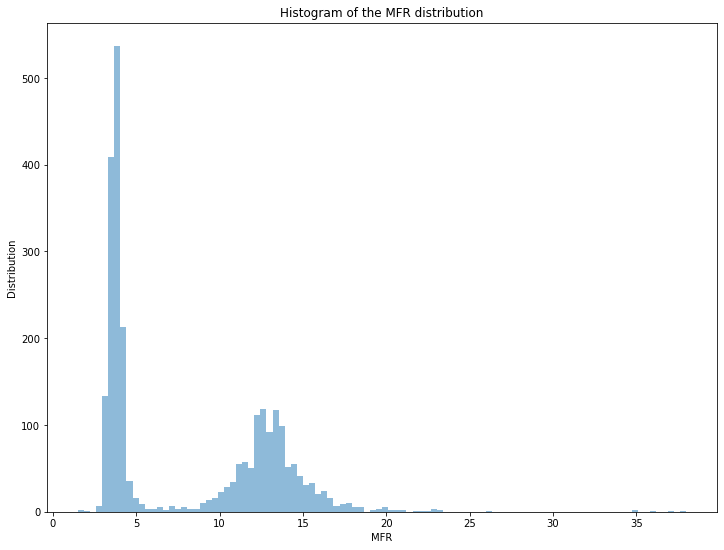

In [12]:
plt.figure(figsize=[12,9])

plt.hist(data['MFR'], bins = 100, alpha=.5)

plt.xlabel("MFR")
plt.ylabel("Distribution")


plt.title("Histogram of the MFR distribution")
plt.show()

In [13]:
lower = data['MFR'].quantile(0.01)
upper = data['MFR'].quantile(0.99) 

print(lower)
print(upper)

3.1
19.547999999999956


In [14]:
#Taking data that lies between the min and max

In [15]:
data = data.query('MFR> 3 and MFR< 20')

In [16]:
#Plotting the correlation plot

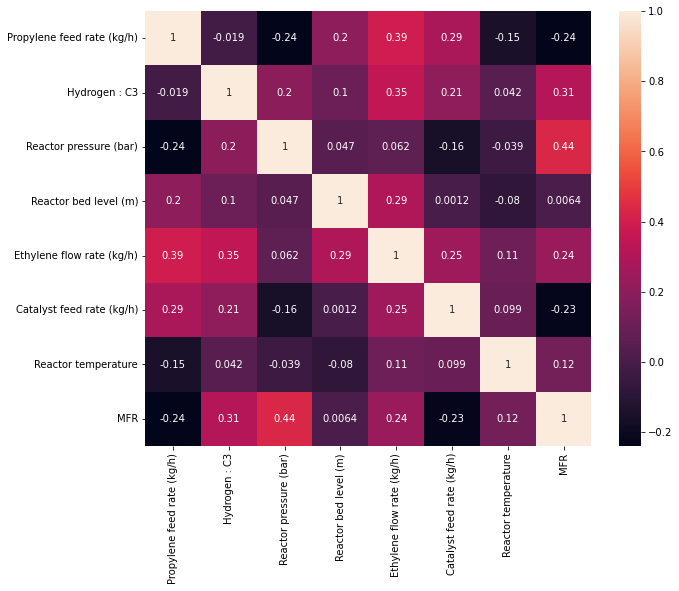

In [17]:
plt.figure(figsize=(10,8))
corr = data.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [18]:
data['ln(MFR)'] =  np.log(data['MFR'])

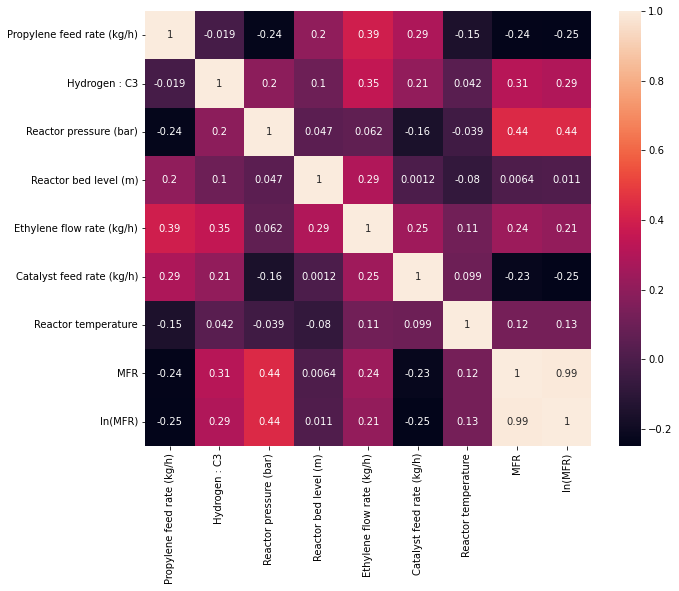

In [19]:
plt.figure(figsize=(10,8))
corr = data.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [20]:
data=data.drop('MFR',axis=1)

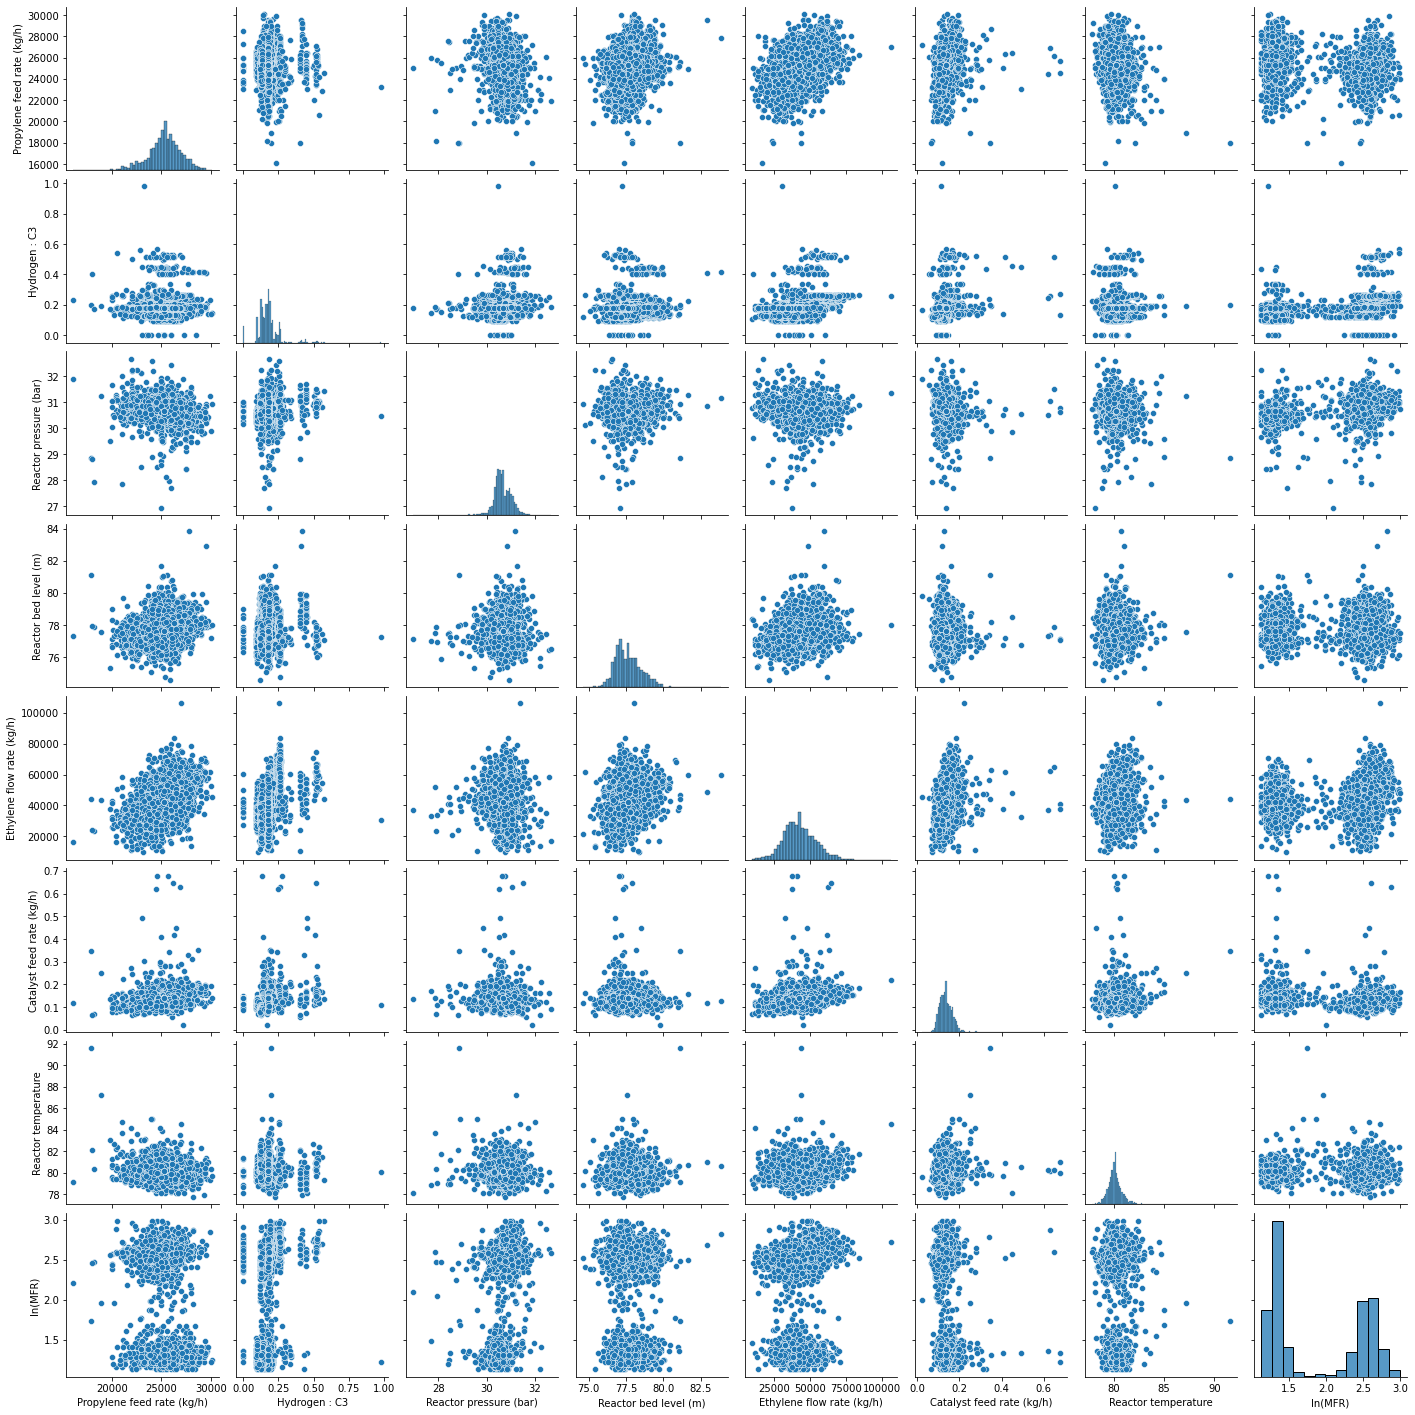

In [21]:
sns.pairplot(data)

In [22]:
target = data['ln(MFR)']
features = data.drop('ln(MFR)', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [23]:
len(features_test)

630

# Scaling

In [24]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train= scaler.transform(features_train)
features_test = scaler.transform(features_test)

# Decision Tree Regression

In [25]:
from sklearn.tree import DecisionTreeRegressor
for depth in range(1, 15):
    pipeline = Pipeline([('Scaler', StandardScaler()), ('DTR', DecisionTreeRegressor(max_depth=depth,random_state=12345))])
    pipeline.fit(features_train, target_train)
    predicted_target_dtr = pipeline.predict(features_test)
    print("max_depth =", depth, ":", mean_squared_error(target_test, predicted_target_dtr)**0.5)

max_depth = 1 : 0.4829851253315914
max_depth = 2 : 0.4363184247925858
max_depth = 3 : 0.40469067444838047
max_depth = 4 : 0.4035432229724081
max_depth = 5 : 0.38453063643661706
max_depth = 6 : 0.36463750910791093
max_depth = 7 : 0.3611452217917836
max_depth = 8 : 0.3633853890900513
max_depth = 9 : 0.37332101646966637
max_depth = 10 : 0.37351839290494876
max_depth = 11 : 0.37722108758813
max_depth = 12 : 0.3824761004636607
max_depth = 13 : 0.38982560252976917
max_depth = 14 : 0.39575195066065977


# K-Nearest Neighbors Regression

In [26]:
pipeline = Pipeline([('Scaler', StandardScaler()), ('KNR', KNeighborsRegressor())])
pipeline.fit(features_train, target_train)
predicted_target_knr = pipeline.predict(features_test)

print('RMSE -', mean_squared_error(target_test, predicted_target_knr)**0.5)

RMSE - 0.33147477555396954


# CatBoost

In [27]:
catboost = CatBoostRegressor(loss_function='RMSE',iterations=250, logging_level='Silent')
parameters_cat = {'depth':[1,8], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(features_train,target_train),cv=3, verbose=100, plot=False)

0:	loss: 0.3514593	best: 0.3514593 (0)	total: 87.8ms	remaining: 790ms
9:	loss: 0.4161091	best: 0.2848509 (5)	total: 1.92s	remaining: 0us
Estimating final quality...


In [28]:
model = CatBoostRegressor(depth=8, learning_rate=0.1, random_state=19072020, iterations=250, logging_level='Silent') 
model.fit(features_train,target_train, verbose=2)

In [29]:
predicted_target_train = model.predict(features_train)
predicted_target = model.predict(features_test)
print('RMSE - Train Case :-', mean_squared_error(target_train, predicted_target_train)**0.5)
print('RMSE - Test Case :-', mean_squared_error(target_test, predicted_target)**0.5)

#Least RMSE or mean squared error in this case on the test case, so choosinng this to go ahead

RMSE - Train Case :- 0.10711084066600009
RMSE - Test Case :- 0.2672260276231973


In [30]:
accuracy_train = model.score(features_train, predicted_target_train)
print("R2 - Train", ":", accuracy_train)
accuracy_test = model.score(features_test, target_test)
print("R2 - Test", ":", accuracy_test)

NameError: name 'accuracy' is not defined

In [ ]:
predicted_target_train_actual = np.e**predicted_target_train
target_train_actual = np.e**target_train
predicted_target_actual = np.e**predicted_target
target_test_actual = np.e**target_test

In [ ]:
x_train = []
for i in range(0,len(target_train)):
    x_train.append(i)

In [ ]:
x_test = []
for i in range(0,len(target_test)):
    x_test.append(i)

In [ ]:
plt.figure(figsize=[12,9])
plt.scatter(x_train,predicted_target_train-target_train,label = 'Predicted-Actual')
plt.xlabel("Serial Number")
plt.ylabel("Difference between predicted and actual in log scale")
plt.title("Plot of difference between predicted and actual MFR in log scale for train case")
plt.show()

In [ ]:
plt.figure(figsize=[12,9])
plt.scatter(x_train,predicted_target_train_actual-target_train_actual,label = 'Predicted-Actual')
plt.xlabel("Serial Number")
plt.ylabel("Difference between predicted and actual in log scale")
plt.title("Plot of difference between predicted and actual MFR for train case")
plt.show()

In [ ]:
plt.figure(figsize=[12,9])
plt.scatter(x_test,predicted_target-target_test,label = 'Predicted-Actual')
plt.xlabel("Serial Number")
plt.ylabel("Difference between predicted and actual in log scale")
plt.title("Plot of difference between predicted and actual MFR in log scale for test case")
plt.show()

In [ ]:
plt.figure(figsize=[12,9])
plt.scatter(x_test,predicted_target_actual-target_test_actual,label = 'Predicted-Actual')
plt.xlabel("Serial Number")
plt.ylabel("Difference between predicted and actual")
plt.title("Plot of difference between predicted and actual MFR for test case")
plt.show()